**IMAGE TEXT RECOGNITION**

---

*USING CONVOLUTION NEURAL NETWORK, RECURRENT NEURAL NETWORK (LSTM) AND CTC AS LOSS FUNCTION*


# **DATA PREPARATION**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [ ]:
!ls
!mv dataset/train/annotation_train.txt dataset/
!mv dataset/test/annotation_test.txt dataset/

dataset  drive	sample_data


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os 
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import image
import itertools
import tensorflow as tf

In [ ]:
def Extract_image_names(file_path,number):
    with open(file_path) as f:
        file_names=f.readlines()
        f.close()
        count=0
        img_names=[]
        labels=[]
        for file in file_names:
            try:
              _,label,_=file.split('_')
              if len(label)<=10:
                  labels.append(label.upper().ljust(10))
                  img_names.append("dataset/"+file_path.split("_")[1].split(".")[0]+"/"+file)
                  count+=1
              if count==number:
                  break
            except:
              print(file)
        img_names=[x.strip() for x in img_names]
        return img_names,labels

In [ ]:
train_images,train_y = Extract_image_names('dataset/annotation_train.txt',50000)
test_images,test_y = Extract_image_names('dataset/annotation_test.txt',20000)

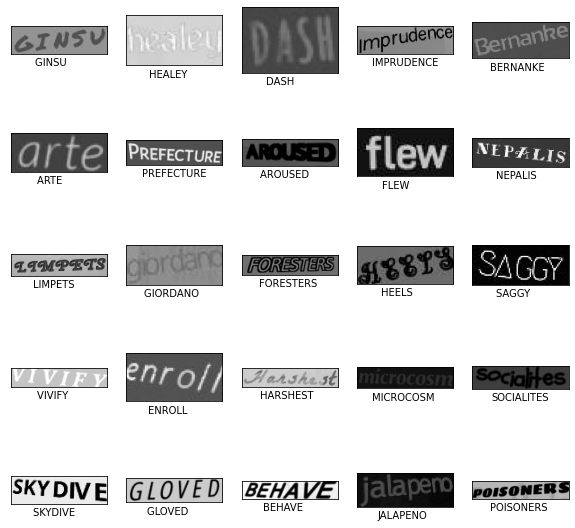

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.array(plt.imread(train_images[i+10])))
    plt.xlabel(train_y[i+10])
plt.show()

# **EXPLORATORY DATA ANALYSIS**

In [ ]:
images=np.array([plt.imread(i).shape for i in train_images])
height=np.array([i[0] for i in images])
width=np.array([i[1] for i in images])
length=np.array([len(i.strip()) for i in train_y])

In [ ]:
print("Train Images Height 90 percentile :",np.percentile(height,90))
print("Train Images Height 99 percentile :",np.percentile(height,99))
print("Train Images Width 90 percentile :",np.percentile(width,90))
print("Train Images Width 99 percentile :",np.percentile(width,99))

Train Images Height 90 percentile : 31.0
Train Images Height 99 percentile : 32.0
Train Images Width 90 percentile : 159.0
Train Images Width 99 percentile : 227.0


In [ ]:
def plot_cdf(quantity,name):
    plt.figure(figsize=(10,6))
    counts, bin_edges = np.histogram(quantity, bins=8, density = True)
    pdf = counts/(sum(counts))
    cdf=np.cumsum(pdf)
    plt.plot(bin_edges[1:],cdf)
    plt.xlabel(name+' of Images',fontsize=10)
    plt.ylabel('CDF',fontsize=10)
    plt.title('CDF Plot of Image '+name,fontsize=12)
    plt.show()

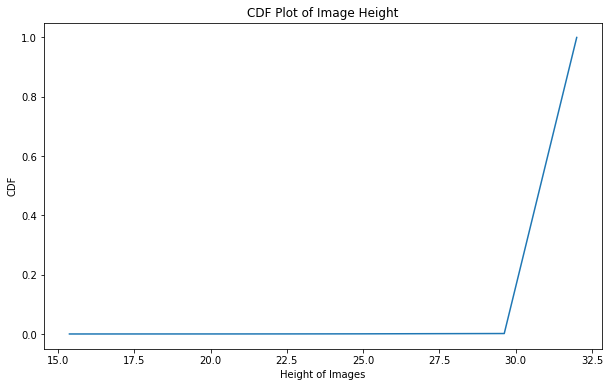

In [ ]:
plot_cdf(height,"Height")

In [ ]:
for i in range(10):
    print("Train Images Width "+str(90+i)+ " percentile :",np.percentile(width,90+i))

Train Images Width 90 percentile : 159.0
Train Images Width 91 percentile : 162.0
Train Images Width 92 percentile : 165.0
Train Images Width 93 percentile : 169.0
Train Images Width 94 percentile : 174.0
Train Images Width 95 percentile : 179.0
Train Images Width 96 percentile : 186.0
Train Images Width 97 percentile : 194.0
Train Images Width 98 percentile : 205.0
Train Images Width 99 percentile : 227.0


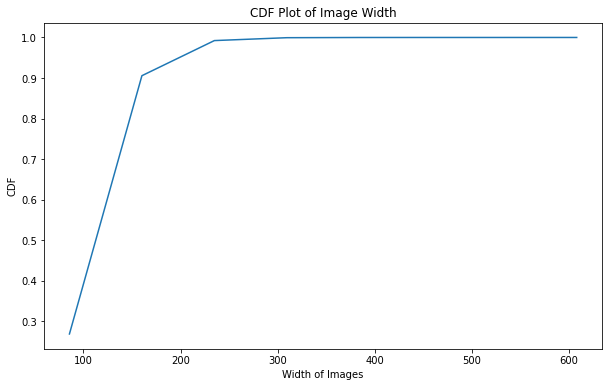

In [ ]:
plot_cdf(width,"Width")

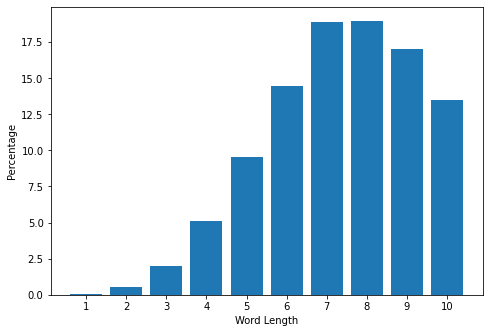

In [ ]:

labelLength=np.histogram(length)[0]
labelPercent=np.array([i/len(length)*100 for i in labelLength])
wordLength=np.arange(1,11)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xlabel('Word Length')
plt.ylabel('Percentage')
ax.set_xticks(np.arange(len(wordLength)+1))
ax.bar(wordLength,labelPercent)
plt.show()

# **IMAGE PRE-PROCESSING**

In [ ]:
def Pixel_array(files):
  output=[]
  for i in files:
    x=Image.open(i,'r')
    x=x.convert('L').resize((170,32))
    y=np.array(x).reshape((x.size[1],x.size[0]))
    y = y.reshape(y.shape + (1,)).transpose(1,0,2)
    output.append(y)
  return output

In [ ]:

train_x=np.asarray(Pixel_array(train_images))
test_x=np.asarray(Pixel_array(test_images))

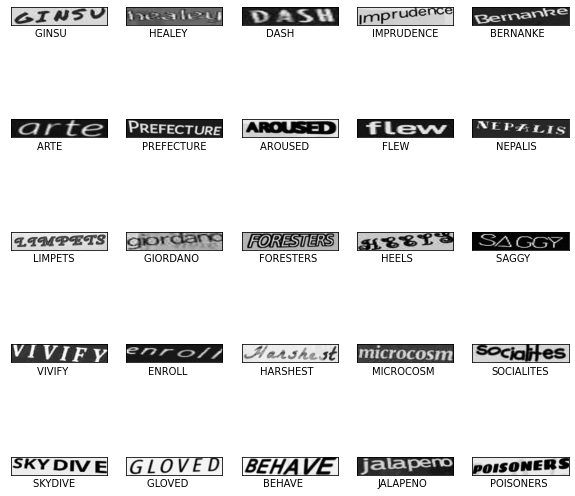

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i+10][:,:,0].transpose(1,0),cmap="gray")
    plt.xlabel(train_y[i+10])
plt.show()

In [ ]:
def normalize(x):
  x=x.astype("float32")
  x-=122.5
  x/=255
  return x

In [ ]:
train_x = normalize(train_x)
test_x = normalize(test_x)
train_y=np.array(train_y)
test_y=np.array(test_y)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(50000, 170, 32, 1)
(50000,)
(20000, 170, 32, 1)
(20000,)


# **DATASET OBJECT CREATION**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
batch_size = 256
characters="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 "
img_width = 170
img_height = 32

In [ ]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def encode_single_sample(img, label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.cast(label,tf.uint8)
    return {"image": img, "label": label}

/usr/local/lib/python3.8/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

tf.Tensor([15 11  0 13 13  8 13  6 18 36], shape=(10,), dtype=uint8)


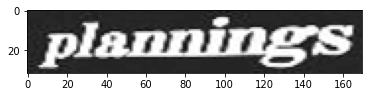

In [ ]:
for batch in validation_dataset.take(25):
    batch_images = batch["image"]
    batch_labels = batch["label"]
print(batch_labels[0])
plt.imshow(np.array(batch_images[0][:,:,0]).transpose(1,0),cmap="gray")

# **MODEL**

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None,**kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [ ]:

def build_model():

    # Input W * 32 gray-scale image
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="uint8")

    # Convolution #maps:64, k3x3, s1x1, p1x1
    # MaxPooling k2x2, s2x2
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(input_img)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x)

    # Convolution #maps:128, k3x3, s1x1, p1x1
    # MaxPooling k2x2, s2x2
    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(x)

    # Convolution #maps:256, k3x3, s1x1, p1x1, bn
    # Convolution #maps:256, k3x3, s1x1, p1x1
    # MaxPooling k2x2, s1x2
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x=layers.BatchNormalization()(x)
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,2))(x)
    
    # Convolution #maps:512, k3x3, s1x1, p1x1, bn
    # Convolution #maps:512, k3x3, s1x1, p1x1
    # MaxPooling k2x2, s1x2
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x=layers.BatchNormalization()(x)
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,2))(x)
    
    # Convolution #maps:512, k2x2, s1x1, bn
    x = layers.Conv2D(
        512,
        (2, 2),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
    )(x)
    x=layers.BatchNormalization()(x)

    # Map-to-Sequence
    new_shape = (40, 1024)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    # Bidirectional-LSTM #hidden units:256
    # Bidirectional-LSTM #hidden units:256
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)

    # Transcription
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model


model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 170, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 170, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 85, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 85, 16, 128)  73856       ['max_pooling2d[0][0]'

# **TRAINING**

In [ ]:
epochs = 10
early_stopping_patience = 5

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/10
782/782 [==============================] - 373s 419ms/step - loss: 25.0355 - val_loss: 5.6988
Epoch 2/10
782/782 [==============================] - 328s 418ms/step - loss: 3.8797 - val_loss: 2.2871
Epoch 3/10
782/782 [==============================] - 324s 413ms/step - loss: 2.0750 - val_loss: 1.8041
Epoch 4/10
782/782 [==============================] - 323s 413ms/step - loss: 1.6224 - val_loss: 1.6556
Epoch 5/10
782/782 [==============================] - 323s 412ms/step - loss: 1.3954 - val_loss: 1.5520
Epoch 6/10
782/782 [==============================] - 322s 411ms/step - loss: 1.2306 - val_loss: 1.4861
Epoch 7/10
782/782 [==============================] - 323s 413ms/step - loss: 1.1054 - val_loss: 1.4896
Epoch 8/10
782/782 [==============================] - 322s 412ms/step - loss: 1.0277 - val_loss: 1.4529
Epoch 9/10
782/782 [==============================] - 322s 411ms/step - loss: 0.9460 - val_loss: 1.4367
Epoch 10/10
782/782 [==============================] - 322s 412

In [ ]:
#model.save('/content/drive/My Drive/10wmodel/ocr', save_format="h5")

# **INFERENCE**

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/10wModel', custom_objects={'CTCLayer': CTCLayer})

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

NameError: ignored

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 170, 32, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 170, 32, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 8, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 8, 256)        295168

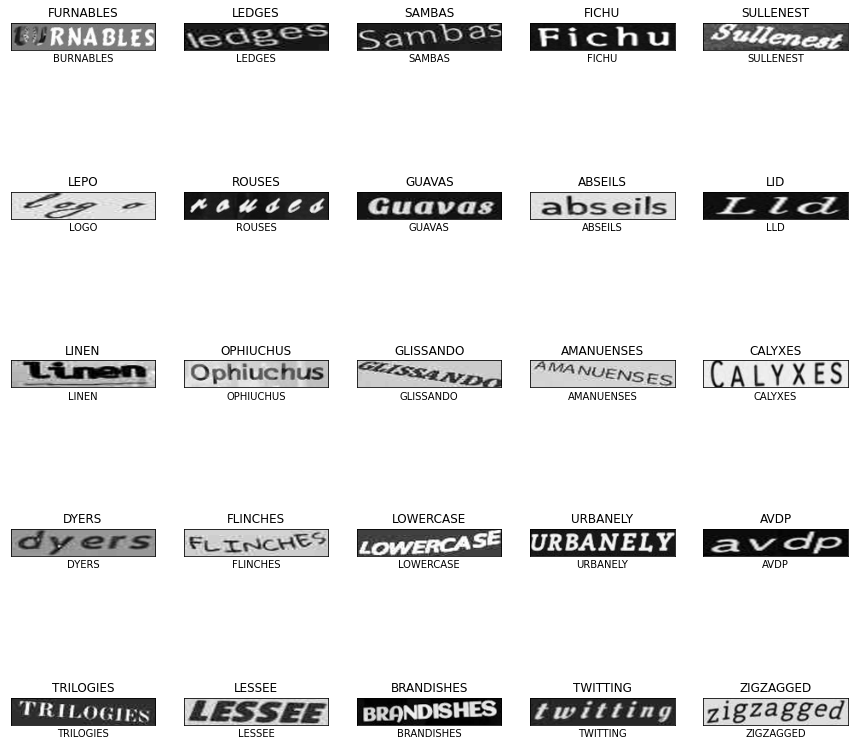

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :10
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res+1)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

preds = prediction_model.predict(test_x)
pred_texts = decode_batch_predictions(preds)
pred_texts=[i.replace("[UNK]","").strip() for i in pred_texts]
c=0

for i in range(len(pred_texts)):
  if(pred_texts[i]==test_y[i].strip()):
    c+=1

accuracy=c/len(test_y)*100
print("\nWord Accuracy: "+str(accuracy)+" %\n")

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(pred_texts[i])
    plt.xlabel(test_y[i].strip())
    plt.imshow(test_x[i][:,:,0].transpose(1,0),cmap="gray")
plt.show()

# **MAKING NEW PREDICTIONS**

Though our model was not trained on handwritten texts, still it was worth testing some images not in the dataset.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WhatsApp Image 2022-12-20 at 10.09.58 PM.jpeg to WhatsApp Image 2022-12-20 at 10.09.58 PM.jpeg


In [ ]:
def pred_sample(img_name):
  prediction_model = keras.models.Model(
      model.get_layer(name="image").input, model.get_layer(name="dense2").output
  )

  def decode_batch_predictions(pred):
      input_len = np.ones(pred.shape[0]) * pred.shape[1]
      results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
          :, :10
      ]
      output_text = []
      for res in results:
          res = tf.strings.reduce_join(num_to_char(res+1)).numpy().decode("utf-8")
          output_text.append(res)
      return output_text

  plt.imshow(plt.imread(img_name))
  pred_img=np.array(Pixel_array([img_name]))
  pred_img=normalize(pred_img)
  preds = prediction_model.predict(pred_img)
  pred_texts = decode_batch_predictions(preds)
  print("PREDICTED TEXT: "+pred_texts[0].replace("[UNK]","").strip())

1/1 [==============================] - 2s 2s/step
PREDICTED TEXT: SIMRAN


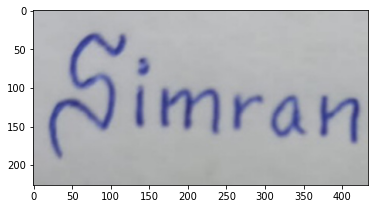

In [ ]:
pred_sample('WhatsApp Image 2022-12-20 at 10.09.58 PM.jpeg')